The goal of this notebook is to use historical data from a loan company to develop a model which is going to be able to determine whether a loan request should be approved or denied when the customer 

In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
import os
os.getcwd()

'c:\\Data_Science\\IH_Notebooks\\home_loan_approval'

In [3]:
train = pd.read_csv('c:/Data_Science/IH_Notebooks/home_loan_approval/loan_sanction_train.csv')
test = pd.read_csv('c:/Data_Science/IH_Notebooks/home_loan_approval/loan_sanction_test.csv')

train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
train['Married'] = train['Married'].fillna('No')
train['Dependents'] = train['Dependents'].fillna(0)
train['Self_Employed'] = train['Self_Employed'].fillna('No')
train['LoanAmount'] = train['LoanAmount'].fillna(train['LoanAmount'].mean())
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mean())
train['Credit_History'] = train['Credit_History'].fillna(0)


In [6]:
train = train.dropna()

In [7]:
num = train.select_dtypes(include='number')
cat = train.select_dtypes(exclude='number')

In [8]:
cat = cat.drop(columns='Loan_Status')

In [9]:
#chi2 correlation test for cat values

chi2_results = []

#for loop to iterate over cat features

for feature in cat:
    contingency_table = pd.crosstab(train[feature], train['Loan_Status'])

    _, p, _, _ = chi2_contingency(contingency_table)

    chi2_results.append({
        'Feature' : feature,
        'p-value' : p,
        'Significant (p < 0.05)' : p< 0.05 
    })

chi2_df = pd.DataFrame(chi2_results).sort_values(by='p-value')

print(chi2_df)

         Feature   p-value  Significant (p < 0.05)
6  Property_Area  0.002243                    True
2        Married  0.038668                    True
4      Education  0.052975                   False
3     Dependents  0.255940                   False
0        Loan_ID  0.480820                   False
1         Gender  0.708653                   False
5  Self_Employed  0.747003                   False


After running the chi2 test for all of the categorical values we can confirm that only 2 features have statistical meaning to the target:

- Property_Area
- Married

The rest of the features can be dropped to facilitate the learning phase of the model.

I'm going to proceed and create a correlation matrix but in order for me to do that I will need to encode the dataframe accordingly.

In [10]:
#dropping columns which are no longer needed

train = train.drop(columns=['Education', 'Dependents', 'Loan_ID', 'Gender', 'Self_Employed'])

train.sample(10)

,Married,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
280,No,4053,2426.0,158.0,360.0,0.0,Urban,N
470,Yes,3450,2079.0,162.0,360.0,1.0,Semiurban,Y
444,Yes,7333,8333.0,175.0,300.0,0.0,Rural,Y
120,Yes,5667,2667.0,180.0,360.0,1.0,Rural,Y
394,Yes,3100,1400.0,113.0,360.0,1.0,Urban,Y
504,Yes,3814,1483.0,124.0,300.0,1.0,Semiurban,Y
247,Yes,6608,0.0,137.0,180.0,1.0,Urban,Y
512,Yes,3283,2035.0,148.0,360.0,1.0,Urban,Y
313,Yes,5746,0.0,144.0,84.0,0.0,Rural,Y
374,No,2764,1459.0,110.0,360.0,1.0,Urban,Y


In [11]:
train.columns = train.columns.str.lower()

In [12]:
property_grouped = train.groupby('property_area')['applicantincome'].mean()
property_grouped

property_area
Rural        5507.805714
Semiurban    5261.035242
Urban        5152.095477
Name: applicantincome, dtype: float64

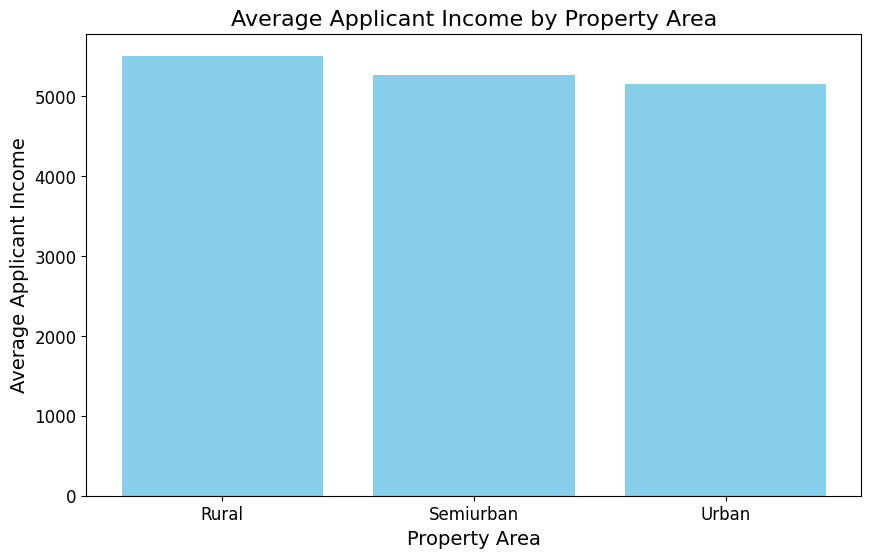

In [13]:
#plotting the grouped data

bars = property_grouped.index
height = property_grouped.values
x_pos = range(len(bars))

plt.figure(figsize=(10, 6))
plt.bar(x_pos, height, color='skyblue')

plt.xticks(x_pos, bars, color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
plt.xlabel('Property Area', fontsize=14)
plt.ylabel('Average Applicant Income', fontsize=14)
plt.title('Average Applicant Income by Property Area', fontsize=16)

plt.show()

In [14]:
property_filtered_rural = train.copy()

property_filtered_rural = property_filtered_rural.loc[(property_filtered_rural['property_area'] == 'Rural')]

In [15]:
property_filtered_semi = train.copy()
property_filtered_semi = property_filtered_semi.loc[(property_filtered_semi['property_area'] == 'Semiurban')]

In [16]:
property_filtered_urban = train.copy()
property_filtered_urban = property_filtered_urban.loc[(property_filtered_urban['property_area'] == 'Semiurban')]

In [17]:
crosstab_rural = pd.crosstab(property_filtered_rural['property_area'], property_filtered_rural['loan_status'])
crosstab_rural

loan_status,N,Y
property_area,,
Rural,67,108


In [18]:
crosstab_semi = pd.crosstab(property_filtered_semi['property_area'], property_filtered_semi['loan_status'])
crosstab_semi

loan_status,N,Y
property_area,,
Semiurban,52,175


In [19]:
crosstab_urban = pd.crosstab(property_filtered_urban['property_area'], property_filtered_urban['loan_status'])
crosstab_urban

loan_status,N,Y
property_area,,
Semiurban,52,175


The requests stemming from the rural area present a higher mean of income, followed by the semiurban and urban area.

Above we can see the bivariate analysis for all of the 3 areas.

In the future we might create a new numerical column for the train df which would be the result of the requestant income + the income of the partner.

In [20]:
#encoding the categorical features of train

married_dummies = pd.get_dummies(train["married"], prefix="married", dtype=int)
married_dummies

,married_No,married_Yes
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0
...,...,...
609,1,0
610,0,1
611,0,1
612,0,1


In [21]:
train = pd.concat([train, married_dummies], axis=1)

train

,married,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status,married_No,married_Yes
0,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,1,0
1,Yes,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1
2,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,0,1
3,Yes,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1
4,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,1,0
...,...,...,...,...,...,...,...,...,...,...
609,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,1,0
610,Yes,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1
611,Yes,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1
612,Yes,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1


In [22]:
loan_dummies = pd.get_dummies(train['loan_status'], prefix='loan', dtype=int)
loan_dummies

,loan_N,loan_Y
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
609,0,1
610,0,1
611,0,1
612,0,1


In [23]:
train = pd.concat([train, loan_dummies], axis= 1)
train

,married,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status,married_No,married_Yes,loan_N,loan_Y
0,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,1,0,0,1
1,Yes,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1,1,0
2,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,0,1,0,1
3,Yes,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1,0,1
4,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,1,0,0,1
610,Yes,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1,0,1
611,Yes,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1,0,1
612,Yes,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1,0,1


In [24]:
urban_area_dummiers = pd.get_dummies(train['property_area'], dtype= int)
urban_area_dummiers

,Rural,Semiurban,Urban
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
609,1,0,0
610,1,0,0
611,0,0,1
612,0,0,1


In [25]:
train = pd.concat([train, urban_area_dummiers], axis=1)
train

,married,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status,married_No,married_Yes,loan_N,loan_Y,Rural,Semiurban,Urban
0,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,1,0,0,1,0,0,1
1,Yes,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1,1,0,1,0,0
2,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1
3,Yes,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1
4,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,1,0,0,1,1,0,0
610,Yes,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1,0,1,1,0,0
611,Yes,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1
612,Yes,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1


In [26]:
train = train.drop(columns= ['married', 'property_area', 'loan_status'])
train

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,loan_N,loan_Y,Rural,Semiurban,Urban
0,5849,0.0,146.412162,360.0,1.0,1,0,0,1,0,0,1
1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,1,0,0
2,3000,0.0,66.000000,360.0,1.0,0,1,0,1,0,0,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,1,0,0,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,360.0,1.0,1,0,0,1,1,0,0
610,4106,0.0,40.000000,180.0,1.0,0,1,0,1,1,0,0
611,8072,240.0,253.000000,360.0,1.0,0,1,0,1,0,0,1
612,7583,0.0,187.000000,360.0,1.0,0,1,0,1,0,0,1


In [27]:
train.columns

Index(['applicantincome', 'coapplicantincome', 'loanamount',
       'loan_amount_term', 'credit_history', 'married_No', 'married_Yes',
       'loan_N', 'loan_Y', 'Rural', 'Semiurban', 'Urban'],
      dtype='object')

In [28]:
test.columns = test.columns.str.lower()

test = test.drop(columns=['loan_id', 'gender'])

In [29]:
test = test.dropna()

In [30]:
test

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area
0,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
4,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
5,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...
361,Yes,1,Graduate,No,2269,2167,99.0,360.0,1.0,Semiurban
362,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
365,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural


In [31]:
#encoding the categorical features of train

married_test_dummies = pd.get_dummies(test["married"], prefix="married", dtype=int)
married_test_dummies

,married_No,married_Yes
0,0,1
1,0,1
2,0,1
4,1,0
5,0,1
...,...,...
361,0,1
362,0,1
363,0,1
365,0,1


In [32]:
urban_area_test_dummiers = pd.get_dummies(test['property_area'], dtype= int)
urban_area_test_dummiers

,Rural,Semiurban,Urban
0,0,0,1
1,0,0,1
2,0,0,1
4,0,0,1
5,0,0,1
...,...,...,...
361,0,1,0
362,0,0,1
363,0,0,1
365,1,0,0


In [33]:
test = pd.concat([test, married_test_dummies], axis=1)
test

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,married_No,married_Yes
0,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,0,1
1,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,0,1
2,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,0,1
4,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,1,0
5,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
361,Yes,1,Graduate,No,2269,2167,99.0,360.0,1.0,Semiurban,0,1
362,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban,0,1
363,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban,0,1
365,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural,0,1


In [34]:
test = pd.concat([test, urban_area_test_dummiers], axis=1)
test

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,married_No,married_Yes,Rural,Semiurban,Urban
0,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,0,1,0,0,1
1,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,0,1,0,0,1
2,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,0,1,0,0,1
4,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,1,0,0,0,1
5,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,Yes,1,Graduate,No,2269,2167,99.0,360.0,1.0,Semiurban,0,1,0,1,0
362,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban,0,1,0,0,1
363,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban,0,1,0,0,1
365,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural,0,1,1,0,0


In [35]:
train

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,loan_N,loan_Y,Rural,Semiurban,Urban
0,5849,0.0,146.412162,360.0,1.0,1,0,0,1,0,0,1
1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,1,0,0
2,3000,0.0,66.000000,360.0,1.0,0,1,0,1,0,0,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,1,0,0,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,360.0,1.0,1,0,0,1,1,0,0
610,4106,0.0,40.000000,180.0,1.0,0,1,0,1,1,0,0
611,8072,240.0,253.000000,360.0,1.0,0,1,0,1,0,0,1
612,7583,0.0,187.000000,360.0,1.0,0,1,0,1,0,0,1


In [36]:
test = test.drop(columns=['married', 'dependents', 'education', 'self_employed', 'property_area'])
test

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban
0,5720,0,110.0,360.0,1.0,0,1,0,0,1
1,3076,1500,126.0,360.0,1.0,0,1,0,0,1
2,5000,1800,208.0,360.0,1.0,0,1,0,0,1
4,3276,0,78.0,360.0,1.0,1,0,0,0,1
5,2165,3422,152.0,360.0,1.0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
361,2269,2167,99.0,360.0,1.0,0,1,0,1,0
362,4009,1777,113.0,360.0,1.0,0,1,0,0,1
363,4158,709,115.0,360.0,1.0,0,1,0,0,1
365,5000,2393,158.0,360.0,1.0,0,1,1,0,0


In [37]:
#moving the target on the right of the df

loan_y_col = train.pop('loan_Y')
train['loan_Y'] = loan_y_col

loan_n_col = train.pop('loan_N')
train['loan_N'] = loan_n_col

train

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y,loan_N
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,1,0
1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,0,0,1
2,3000,0.0,66.000000,360.0,1.0,0,1,0,0,1,1,0
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,1,1,0
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,360.0,1.0,1,0,1,0,0,1,0
610,4106,0.0,40.000000,180.0,1.0,0,1,1,0,0,1,0
611,8072,240.0,253.000000,360.0,1.0,0,1,0,0,1,1,0
612,7583,0.0,187.000000,360.0,1.0,0,1,0,0,1,1,0


In [38]:
#dropping loan_N as redundant

train = train.drop(columns='loan_N')

Now that I have completed the EDA, encoded and prepared the df, I can create a first baseline Logistic Regression model to see how it performs without any hyperparameters tuning.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = train.drop(columns='loan_Y')
y = train['loan_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


baseline = LogisticRegression()

baseline.fit(X_train_scaled, y_train)

print("train data length: ", len(X_train_scaled))
print("test data length", len(X_test_scaled))


train data length:  480
test data length 121


In [40]:
predictions_baseline = baseline.predict(X_test_scaled)

predictions_baseline

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1])

In [41]:
predictions_df = X_test.copy()

predictions_df['loan_Y'] = predictions_baseline

predictions_df['actual_loan_Y'] = y_test

predictions_df

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y,actual_loan_Y
111,2929,2333.0,139.0,360.0,1.0,0,1,0,1,0,1,1
425,2666,4300.0,121.0,360.0,1.0,0,1,1,0,0,1,1
575,3159,461.0,108.0,84.0,1.0,0,1,0,0,1,1,1
78,3167,4000.0,180.0,300.0,0.0,0,1,0,1,0,0,0
184,3625,0.0,108.0,360.0,1.0,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
346,3523,3230.0,152.0,360.0,0.0,0,1,1,0,0,0,0
150,6277,0.0,118.0,360.0,0.0,1,0,1,0,0,0,0
503,4050,5302.0,138.0,360.0,0.0,0,1,1,0,0,0,0
445,3466,1210.0,130.0,360.0,1.0,0,1,1,0,0,1,1


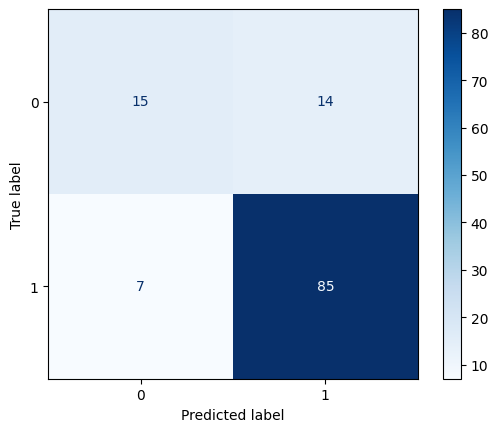

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = predictions_df['actual_loan_Y']
y_pred = predictions_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [43]:
print(classification_report(y_test, predictions_baseline))

              precision    recall  f1-score   support

           0       0.68      0.52      0.59        29
           1       0.86      0.92      0.89        92

    accuracy                           0.83       121
   macro avg       0.77      0.72      0.74       121
weighted avg       0.82      0.83      0.82       121



The model performs fairly good but there's definitely room for improvement.

We can see that the baseline model seems to be better at predicting when the loan should be approved than when it shouldn't.

For the True label we got 7 false negatives and 14 false positives.

I am now going to apply some more feature engineering and hyperparameters tuning as well as reviewing the mismatch in the data between requests being accepted and denied.

In [44]:
loan_y_n_frequency = train['loan_Y'].value_counts()
loan_y_n_frequency

loan_Y
1    414
0    187
Name: count, dtype: int64

As we can see from the above we have a clear mismatch between data which led to approval and data which led to denial.

I'm going to focus on increasing the data which led to denial with synthetic data.

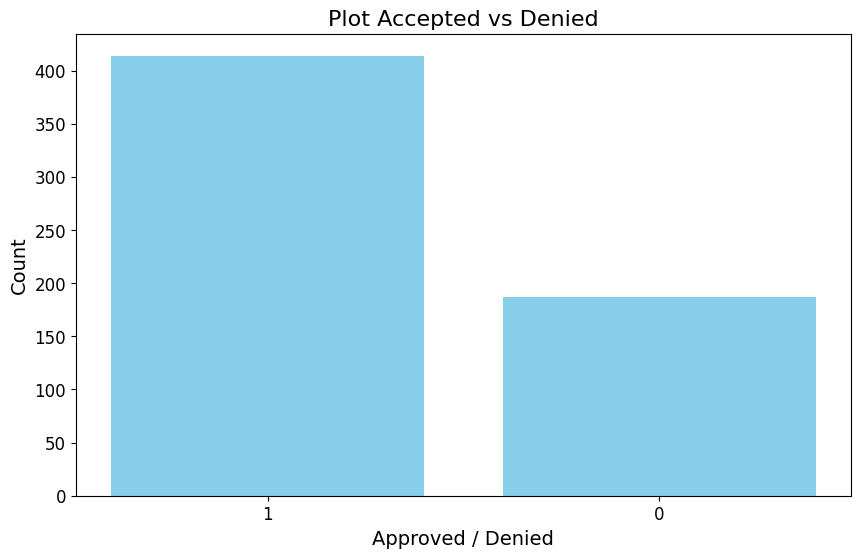

In [45]:
#plotting mismatch between approved and denied in the train data

bars = loan_y_n_frequency.index
height = loan_y_n_frequency.values
x_pos = range(len(bars))

plt.figure(figsize=(10, 6))
plt.bar(x_pos, height, color='skyblue')

plt.xticks(x_pos, bars, color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
plt.xlabel('Approved / Denied', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Plot Accepted vs Denied', fontsize=16)

plt.show()

In [46]:
from sklearn.utils import resample

no_approval = train[train['loan_Y']==0]
approval  = train[train['loan_Y']==1]

oversampled_no_approval = resample(no_approval, replace=True, n_samples=len(approval), random_state=42)  # Reproducible results

display(approval.shape)
display(oversampled_no_approval.shape)



(414, 11)

(414, 11)

In [47]:
train_oversampled = pd.concat([approval, oversampled_no_approval])

train_oversampled

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,1
2,3000,0.0,66.000000,360.0,1.0,0,1,0,0,1,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,1,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,1
5,5417,4196.0,267.000000,360.0,1.0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
36,1828,1330.0,100.000000,342.0,0.0,0,1,0,0,1,0
168,2237,0.0,63.000000,480.0,0.0,1,0,0,1,0,0
328,4333,2451.0,110.000000,360.0,1.0,0,1,0,0,1,0
22,2600,1911.0,116.000000,360.0,0.0,0,1,0,1,0,0


In [48]:
frequency_table_oversampled = train_oversampled['loan_Y'].value_counts()
frequency_table_oversampled

loan_Y
1    414
0    414
Name: count, dtype: int64

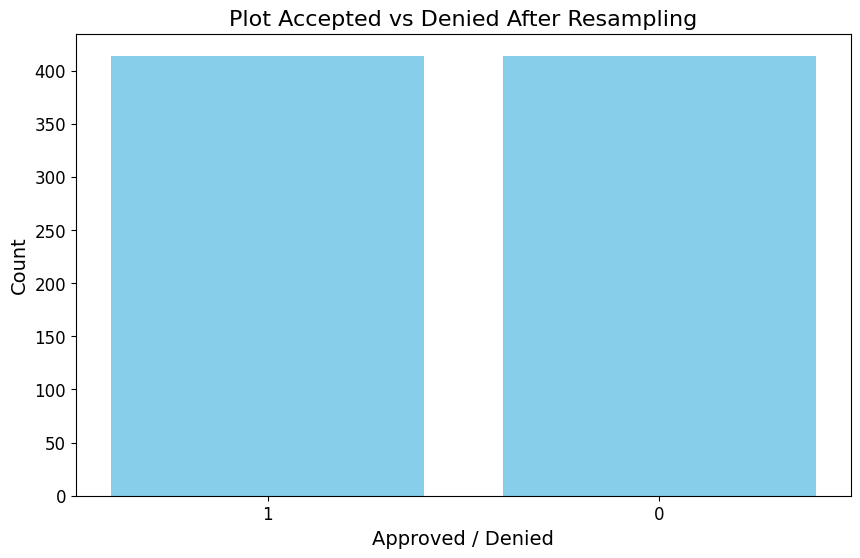

In [49]:
#plotting mismatch between approved and denied in the train data

bars = frequency_table_oversampled.index
height = frequency_table_oversampled.values
x_pos = range(len(bars))

plt.figure(figsize=(10, 6))
plt.bar(x_pos, height, color='skyblue')

plt.xticks(x_pos, bars, color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
plt.xlabel('Approved / Denied', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Plot Accepted vs Denied After Resampling', fontsize=16)

plt.show()

The dataset is now even between approved and denied requests.

I'm now going to fit the model once again and see if this leads to better results.

In [50]:
train_oversampled

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,1
2,3000,0.0,66.000000,360.0,1.0,0,1,0,0,1,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,1,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,1
5,5417,4196.0,267.000000,360.0,1.0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
36,1828,1330.0,100.000000,342.0,0.0,0,1,0,0,1,0
168,2237,0.0,63.000000,480.0,0.0,1,0,0,1,0,0
328,4333,2451.0,110.000000,360.0,1.0,0,1,0,0,1,0
22,2600,1911.0,116.000000,360.0,0.0,0,1,0,1,0,0


In [51]:
scaler = StandardScaler()
X = train_oversampled.drop(columns='loan_Y')
y = train_oversampled['loan_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


oversampled_model = LogisticRegression()

oversampled_model.fit(X_train_scaled, y_train)

print("train data length: ", len(X_train_scaled))
print("test data length", len(X_test_scaled))


train data length:  662
test data length 166


In [52]:
predictions_oversampled = oversampled_model.predict(X_test_scaled)

predictions_oversampled

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1])

In [53]:
predictions_oversampled_df = X_test.copy()

predictions_oversampled_df['loan_Y'] = predictions_oversampled

predictions_oversampled_df['actual_loan_Y'] = y_test

predictions_oversampled_df

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y,actual_loan_Y
597,2987,0.0,88.000000,360.0,0.0,1,0,0,1,0,0,0
52,4230,0.0,112.000000,360.0,1.0,1,0,0,1,0,1,0
429,2717,0.0,60.000000,180.0,1.0,1,0,0,0,1,1,1
524,4680,2087.0,146.412162,360.0,1.0,1,0,0,1,0,1,0
252,2583,2167.0,104.000000,360.0,1.0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
417,1600,20000.0,239.000000,360.0,1.0,0,1,0,0,1,1,0
285,3158,3053.0,89.000000,360.0,1.0,1,0,1,0,0,0,1
527,5285,1430.0,161.000000,360.0,0.0,0,1,0,1,0,0,1
396,3180,0.0,71.000000,360.0,0.0,1,0,0,0,1,0,0


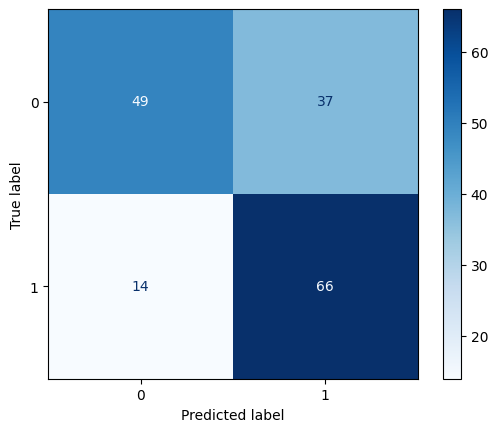

In [54]:
y_true = predictions_oversampled_df['actual_loan_Y']
y_pred = predictions_oversampled_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [55]:
print(classification_report(y_test, predictions_oversampled))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66        86
           1       0.64      0.82      0.72        80

    accuracy                           0.69       166
   macro avg       0.71      0.70      0.69       166
weighted avg       0.71      0.69      0.69       166



After resampling the denied requests the model has improved on the denial requests but became worse on the approvals.

I'm going to try and work on the hyperparameters to see if this can simply be improved by tweaking the model or if further feature engineering needs to be pursued.

In [56]:
#introducing hyperparameters tweaking to improve model performance

hyperparameter_model = LogisticRegression(max_iter=500, solver='liblinear')

hyperparameter_model.fit(X_train_scaled, y_train)

predictions_hyperparameter = hyperparameter_model.predict(X_test_scaled)

In [57]:
predictions_hyperparameter_df = X_test.copy()

predictions_hyperparameter_df['loan_Y'] = predictions_hyperparameter

predictions_hyperparameter_df['actual_loan_Y'] = y_test

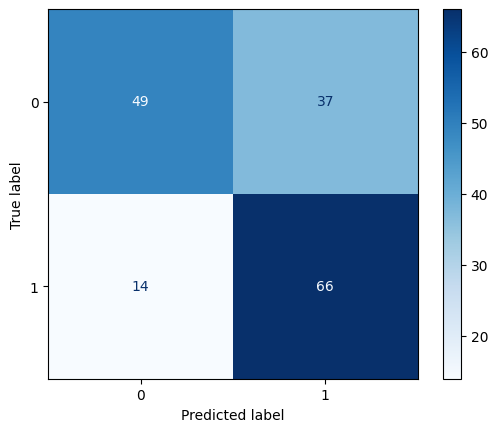

In [58]:
y_true = predictions_hyperparameter_df['actual_loan_Y']
y_pred = predictions_hyperparameter_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [59]:
print(classification_report(y_test, predictions_hyperparameter))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66        86
           1       0.64      0.82      0.72        80

    accuracy                           0.69       166
   macro avg       0.71      0.70      0.69       166
weighted avg       0.71      0.69      0.69       166



Hyperparameters tuning hasn't lead to any improvement.

Considering that the relationship between the features and the target might not be linear I will use different models which perform better on different distributions of the data.

In [60]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier

tree_baseline_model = DecisionTreeClassifier()

tree_baseline_model.fit(X_train_scaled, y_train) #fitting the model

DecisionTreeClassifier()

In [61]:
predictions_tree_baseline = tree_baseline_model.predict(X_test_scaled) #running predictions

predictions_tree_df = X_test.copy()

predictions_tree_df['loan_Y'] = predictions_tree_baseline #casting the predictions onto the df

predictions_tree_df['actual_loan_Y'] = y_test 

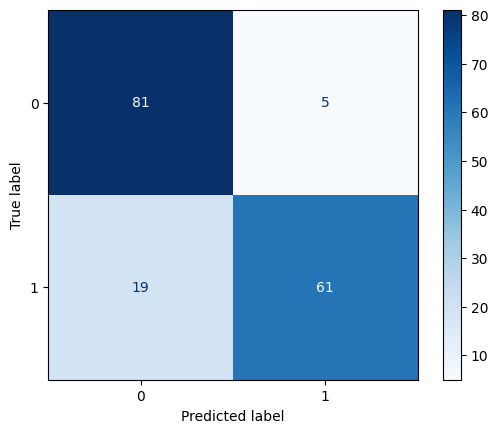

In [62]:
#creating the confusion matrix

y_true = predictions_tree_df['actual_loan_Y']
y_pred = predictions_tree_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [63]:
print(classification_report(y_test, predictions_tree_baseline))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        86
           1       0.92      0.76      0.84        80

    accuracy                           0.86       166
   macro avg       0.87      0.85      0.85       166
weighted avg       0.87      0.86      0.85       166



The Decision Tree model leads to exciting results without any particular feature engineering or hyperparameter tuning.

The model is able to correctly predict 81% of the denied requests and 92% of the approved requests.

I'm going to apply hyperparameters tuning and see I can improve the performance even more.

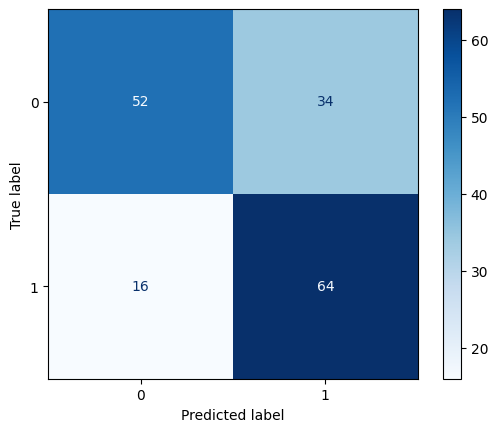

In [64]:
#Decision Tree

tree_hyperparameter = DecisionTreeClassifier(splitter='random',max_depth=5,max_features=3) #applying hyperparameters tuning

tree_hyperparameter.fit(X_train_scaled, y_train) #fitting the model

predictions_tree_hyperparameter = tree_hyperparameter.predict(X_test_scaled) #running predictions

predictions_treehyperpar_df = X_test.copy()

predictions_treehyperpar_df['loan_Y'] = predictions_tree_hyperparameter #casting the predictions onto the df

predictions_treehyperpar_df['actual_loan_Y'] = y_test 

#creating the confusion matrix

y_true = predictions_treehyperpar_df['actual_loan_Y']
y_pred = predictions_treehyperpar_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [65]:
print(classification_report(y_test, predictions_tree_hyperparameter))

              precision    recall  f1-score   support

           0       0.76      0.60      0.68        86
           1       0.65      0.80      0.72        80

    accuracy                           0.70       166
   macro avg       0.71      0.70      0.70       166
weighted avg       0.71      0.70      0.70       166



Hyperparameter tuning has led to worseing of the results.

I'm going to proceed and test different models.

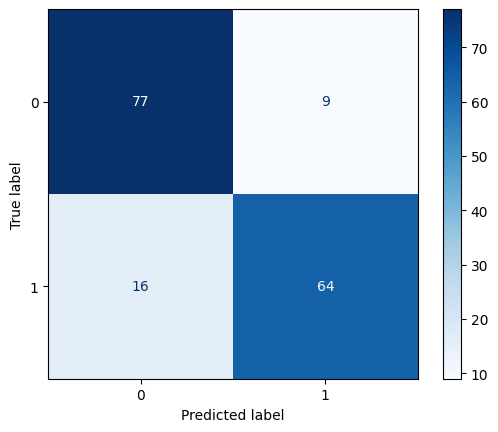

In [67]:
#Decision Tree

from sklearn.ensemble import RandomForestClassifier 

forest_baseline = RandomForestClassifier()

forest_baseline.fit(X_train_scaled, y_train) #fitting the model

predictions_forest_baseline = forest_baseline.predict(X_test_scaled) #running predictions

predictions_forest_df = X_test.copy()

predictions_forest_df['loan_Y'] = predictions_forest_baseline #casting the predictions onto the df

predictions_forest_df['actual_loan_Y'] = y_test 

#creating the confusion matrix

y_true = predictions_forest_df['actual_loan_Y']
y_pred = predictions_forest_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [68]:
print(classification_report(y_test, predictions_forest_baseline))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        86
           1       0.88      0.80      0.84        80

    accuracy                           0.85       166
   macro avg       0.85      0.85      0.85       166
weighted avg       0.85      0.85      0.85       166



In [69]:
#RandomForest hyperparameter tuning

depth = range(1, 30)

forest_hyper = RandomForestClassifier(max_depth=depth)

forest_hyper.fit(X_train_scaled, y_train) #fitting the model

predictions_forest_hyper = forest_hyper.predict(X_test_scaled) #running predictions

predictions_forest_hyper_df = X_test.copy()

predictions_forest_hyper_df['loan_Y'] = predictions_forest_hyper #casting the predictions onto the df

predictions_forest_hyper_df['actual_loan_Y'] = y_test 

#creating the confusion matrix

y_true = predictions_forest_hyper_df['actual_loan_Y']
y_pred = predictions_forest_hyper_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

InvalidParameterError: The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got range(1, 30) instead.